# WIP - Application of CNNs on MNIST dataset

## 1. Importing libraries

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import random as rd

<u><b>Warning:</b></u> This notebook runs on tensorflow version 1.14 (tested using an installation of tensorflow-gpu v1.14.0)

In [2]:
import tensorflow as tf
tf.__version__

'1.14.0'

## 2. Importing datasets
The MNIST datasets are kindly provided by Yann Lecun on his [website](http://yann.lecun.com/exdb/mnist/).

They are directly accessibly through the tensorflow library as seen below.

In [3]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels),(test_images, test_labels) = mnist.load_data()


Image n°49456's label is 6.


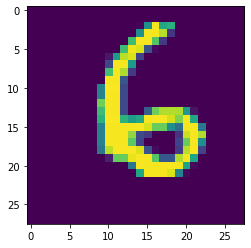

In [4]:
# Testing random image and its label from the training set.
random_image = rd.randrange(train_images.shape[0])
plt.imshow(train_images[random_image])
print("\nImage n°" + str(random_image) + "'s label is " + str(train_labels[random_image]) + ".")

## 3. Data Preprocessing

<u>1. Declaring pre-processing functions:</u>

In [5]:
def convert_to_one_hot(array):
    """
    Converts a numpy array of shape (number_instances, 1) to one-hot encodings
    of shape (number_instances, number_labels)
    ---
    variable <array>: <class 'numpy.ndarray'>
    """    
    # Using np.reshape is necessary so the one-hot encodings are not a nested list.
    new_array = np.array(array).reshape(-1)
    return np.eye(np.max(array)+1)[new_array]

<u>2. Reshaping train and test image/label arrays:</u>

In [6]:
# Expanding by 1 the dimension of train and test images to indicate that MNIST data are 
#in greyscale, i.e. 1 channel
train_images = np.expand_dims(train_images,axis=3)
test_images = np.expand_dims(test_images,axis=3)

# Reshaping labels to indicate the dimension of the secondary axis
train_labels = np.reshape(train_labels,(train_labels.shape[0],1))
test_labels = np.reshape(test_labels,(test_labels.shape[0],1))

print("Dimensions of:",
      "- Training features array: " + str(train_images.shape), 
      "- Training labels array: " + str(train_labels.shape), 
      "- Testing features array: " + str(test_images.shape), 
      "- Testing features array: " + str(test_labels.shape), 
      sep="\n")

Dimensions of:
- Training features array: (60000, 28, 28, 1)
- Training labels array: (60000, 1)
- Testing features array: (10000, 28, 28, 1)
- Testing features array: (10000, 1)


<u>3. Normalizing features:</u>

In [7]:
# Normalizing features. 
norm_train_images = train_images.astype(np.float32)/np.max(train_images) #i.e. /255
norm_test_images = test_images/np.max(test_images) #i.e. /255

<u>4. Converting train and test labels arrays to one-hot encodings:</u>

In [8]:
encoded_train_labels = convert_to_one_hot(train_labels)
encoded_test_labels = convert_to_one_hot(train_labels)

In [9]:
print("Dimensions of:",
      "- Training labels one-hot encoded array:" + str(encoded_train_labels.shape),
      "- Test labels one-hot encoded array:" + str(encoded_test_labels.shape),
      "\nImage n°" + str(random_image) + "'s one-hot encoding is " + \
      str(encoded_train_labels[random_image]) + ".",
      sep="\n")

Dimensions of:
- Training labels one-hot encoded array:(60000, 10)
- Test labels one-hot encoded array:(60000, 10)

Image n°49456's one-hot encoding is [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.].


## 4. Laying out the CNN Model

<u>1. Declaring pre-processing functions:</u>

In [10]:
def instance_shape(array):
    """
    Returns the height, width of instance data.
    ---
    variable <array>: <class 'numpy.ndarray'>
    """
    return array.shape[1], array.shape[2]
    
def tensorflow_placeholders(instance_height, 
                            instance_width, 
                            instance_channels, 
                            label_numbers):
    """
    Creates tensorflow placeholders for a tensorflow session.
    ---
    variables <class 'int'>: <instance_height>, <instance_width>, <instance_channel>, <label_numbers>
    """
    placeholder_data = tf.placeholder(tf.float32, shape=(None,
                                                         instance_height,
                                                         instance_width,
                                                         instance_channels))
    placeholder_labels = tf.placeholder(tf.float32, shape=(None, label_numbers))
    return placeholder_data, placeholder_labels

def initialize_parameters(variable_name, filter_shape):
    """
    Initializes weght parameters and returns returns a tensor with shape:
    [filter_height, filter_width, in_channels, out_channels].
    ---
    variable <class 'int'>: <filter_height>, <filter_width>, <channels_in>, <channels_out>
    variable <class 'lst'>: <filter_shape> (listing variables: <class 'int'>)
    variable <class 'str'>: <variable_name>
    """
    weights = tf.get_variable(variable_name, filter_shape, 
                              initializer = tf.contrib.layers.xavier_initializer(seed=0))
    return weights

<u>2. Setting up tensorflow session structure:</u>

In [11]:
# Seeds random numbers for tensor parameters
tf.set_random_seed(1)

# Scalar used for setting up tensorflow session.
instance_height, instance_width = instance_shape(norm_train_images)
instance_channels = 1
label_numbers = encoded_train_labels.shape[1]

In [12]:
# Creating tensorflow placeholders.
placeholder_data, placeholder_labels = tensorflow_placeholders(instance_height, 
                                                               instance_width, 
                                                               instance_channels, 
                                                               label_numbers)
print("Tensorflow placeholder for instance data:",
      placeholder_data,
      "Tensorflow placeholder for instance labels:",
      placeholder_labels
      , sep="\n")

Tensorflow placeholder for instance data:
Tensor("Placeholder:0", shape=(?, 28, 28, 1), dtype=float32)
Tensorflow placeholder for instance labels:
Tensor("Placeholder_1:0", shape=(?, 10), dtype=float32)


In [13]:
#Creating the weights parameters
convolution_filter_shapes = ([1,1,1,16],
                             [4,4,16,16],
                             [2,2,16,8],
                             [2,2,8,8])

parameters = {"W1":initialize_parameters("W1", convolution_filter_shapes[0]),
              "W2":initialize_parameters("W2", convolution_filter_shapes[1]),
              "W3":initialize_parameters("W3", convolution_filter_shapes[2]),
              "W4":initialize_parameters("W4", convolution_filter_shapes[3])}

#Declaring the hyperparameters
strides = {"cnn_layer_1": [1,1,1,1], 
           "cnn_layer_2": [1,1,1,1], 
           "cnn_layer_3": [1,1,1,1], 
           "cnn_layer_4": [1,1,1,1], 
           "max_pool_layer_1": [1,3,3,1],
           "max_pool_layer_2": [1,3,3,1],
           "max_pool_layer_3": [1,3,3,1],
           "max_pool_layer_4": [1,3,3,1]}

kernel_size = {"max_pool_layer_1": [1,3,3,1], 
               "max_pool_layer_2": [1,3,3,1], 
               "max_pool_layer_3": [1,3,3,1], 
               "max_pool_layer_4": [1,3,3,1]}

padding = {"cnn_layer_1": "SAME", 
           "cnn_layer_2": "SAME", 
           "cnn_layer_3": "SAME", 
           "cnn_layer_4": "SAME", 
           "max_pool_layer_1": "SAME", 
           "max_pool_layer_2": "SAME", 
           "max_pool_layer_3": "SAME", 
           "max_pool_layer_4": "SAME"}

output_layer_size = len(np.unique(train_labels))

hyperparameters = {"strides": strides, 
                   "kernel_size": kernel_size, 
                   "padding": padding, 
                   "output_size": output_layer_size}

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [14]:
def forward_propagation(data, parameters, hyperparameters):
    """
    Implements the forward propagation for the machine learning model.
    ---
    variable <class 'numpy.ndarray'>: data
    variable <class 'dict'>: parameters, hyperparameters
    """
    #############
    ###LAYER 1###
    #CONV2D
    Z1 = tf.nn.conv2d(data, 
                      parameters["W1"], 
                      strides = hyperparameters["strides"]["cnn_layer_1"], 
                      padding = hyperparameters["padding"]["cnn_layer_1"])
    #RELU
    A1 = tf.nn.relu(Z1)
    #MAXPOOL
    P1 = tf.nn.max_pool(A1, 
                        ksize = kernel_size["max_pool_layer_1"], 
                        strides = hyperparameters["strides"]["max_pool_layer_1"], 
                        padding = hyperparameters["padding"]["max_pool_layer_1"])
    #############
    ###LAYER 2###
    #CONV2D
    Z2 = tf.nn.conv2d(P1, 
                      parameters["W1"], 
                      strides = hyperparameters["strides"]["cnn_layer_1"], 
                      padding = hyperparameters["padding"]["cnn_layer_1"])
    #RELU
    A2 = tf.nn.relu(Z2)
    #MAXPOOL
    P2 = tf.nn.max_pool(A2, 
                        ksize = kernel_size["max_pool_layer_1"], 
                        strides = hyperparameters["strides"]["max_pool_layer_1"], 
                        padding = hyperparameters["padding"]["max_pool_layer_1"])
    #############
    ###LAYER 3###
    #CONV2D
    Z3 = tf.nn.conv2d(P2, 
                      parameters["W1"], 
                      strides = hyperparameters["strides"]["cnn_layer_1"], 
                      padding = hyperparameters["padding"]["cnn_layer_1"])
    #RELU
    A3 = tf.nn.relu(Z3)
    #MAXPOOL
    P3 = tf.nn.max_pool(A3, 
                        ksize = kernel_size["max_pool_layer_1"], 
                        strides = hyperparameters["strides"]["max_pool_layer_1"], 
                        padding = hyperparameters["padding"]["max_pool_layer_1"])
    #############
    ###LAYER 4###
    #CONV2D
    Z4 = tf.nn.conv2d(P3, 
                      parameters["W1"], 
                      strides = hyperparameters["strides"]["cnn_layer_1"], 
                      padding = hyperparameters["padding"]["cnn_layer_1"])
    #RELU
    A4 = tf.nn.relu(Z4)
    #MAXPOOL
    P4 = tf.nn.max_pool(A4, 
                        ksize = kernel_size["max_pool_layer_1"], 
                        strides = hyperparameters["strides"]["max_pool_layer_1"], 
                        padding = hyperparameters["padding"]["max_pool_layer_1"])
    #############
    ###LAYER 5###
    #FLATTEN
    F = tf.contrib.layers.flatten(P4)
    #FULLY-CONNECTED
    Z5 = tf.contrib.layers.fully_connected(F, 
                                           hyperparameters["output_size"], 
                                           activation_fn = None)
    return Z5

In [15]:
def cost(data, labels):
    """
    Computes the cost of the model.
    ---
    variables <class 'numpy.ndarray'>: data, labels
    """
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = data, 
                                                                  labels = labels))
    return cost

## 5. Training the CNN Model

In [18]:
status = "WIP"

## 6. Analyzing results

In [19]:
status = "WIP"

## 7. Implementing LeNet

In [20]:
status = "WIP"